<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio de Gestión de Outliers

AutoRenew, la empresa líder en la venta de coches de segunda mano, sigue adelante con el desarrollo del modelo predictivo que ayudará a estimar el precio de los vehículos usados. Este modelo es clave para mejorar las estrategias de ventas, marketing y optimización del inventario de la empresa. Ya has realizado un análisis exploratorio inicial y gestionado los valores nulos en el conjunto de datos. Ahora, es el momento de abordar otro aspecto crucial del preprocesamiento: la **gestión de outliers**.

En este laboratorio, te enfocarás en identificar y gestionar los outliers (valores atípicos) presentes en el conjunto de datos. Los outliers pueden distorsionar los resultados de un análisis y afectar negativamente el rendimiento de los modelos predictivos, por lo que es fundamental tratarlos adecuadamente antes de proceder con las siguientes fases del proyecto.


**Instrucciones:**

1. **Identificación de Outliers:** Explora las columnas clave del conjunto de datos (como `price`, `powerCV`, `kilometer`, etc.) para identificar posibles outliers. Utiliza gráficos como diagramas de caja (boxplots) y análisis estadísticos para detectar valores que se desvíen significativamente del resto de los datos.

2. **Análisis de Outliers:** Una vez identificados, analiza los outliers para determinar si son errores de datos, valores extremos válidos o resultados de condiciones específicas que deben ser tenidos en cuenta. Considera el contexto de cada columna al evaluar la relevancia de estos valores atípicos.

3. **Gestión de Outliers:** Decide la estrategia más adecuada para manejar los outliers. Esto podría incluir la eliminación de los outliers, la transformación de los datos, o la aplicación de técnicas de imputación. Justifica tu elección basándote en cómo los outliers podrían afectar el modelo predictivo.

**Nota:** Recuerda que este laboratorio es parte de una serie de actividades en las que utilizarás el mismo conjunto de datos a lo largo de la semana. Documenta cuidadosamente los pasos que sigas para que puedas referirte a ellos en las próximas etapas del proyecto.


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Otros objetivos
# -----------------------------------------------------------------------
import math

# Gráficos
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px



# Métodos estadísticos
# -----------------------------------------------------------------------
from scipy.stats import zscore # para calcular el z-score
from sklearn.neighbors import LocalOutlierFactor # para detectar outliers usando el método LOF
from sklearn.ensemble import IsolationForest # para detectar outliers usando el metodo IF
from sklearn.neighbors import NearestNeighbors # para calcular la epsilon

# Para generar combinaciones de listas
# -----------------------------------------------------------------------
from itertools import product, combinations

# Gestionar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [2]:
from src import soporte_outliers as so

In [3]:
from src import soporte_preprocesamiento as sp

In [4]:
df = pd.read_csv("datos/robust.csv",index_col=0)

In [5]:
df.head()

,price,powerCV_robust,kilometer_robust
0,480.0,-0.369107,0.0
1,18300.0,1.123815,-1.0
2,9800.0,0.744345,-1.0
3,1500.0,-0.525420,0.0
4,3600.0,-0.612990,-2.4


Los datos de las columnas de powerCV_robust y kilometer_robust están escalados con RobustScaler

### Identificación de outliers

Para comenzar la identificación de outliers, sacamos boxplot de las tres variables para ver sus distribuciones 

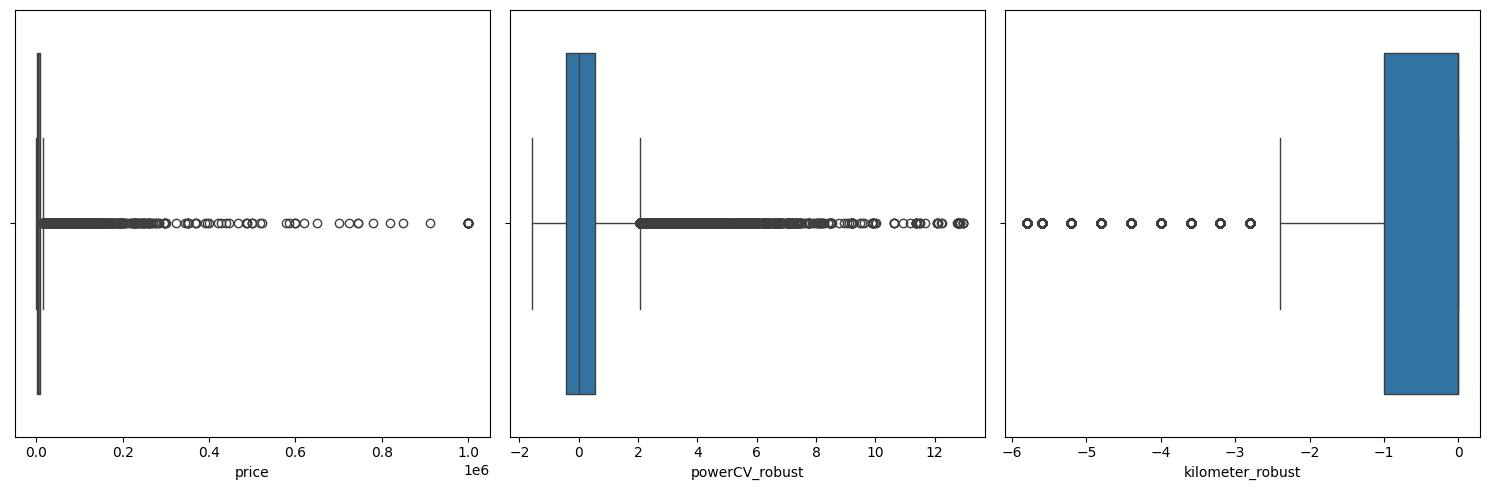

In [6]:
fig , axes = plt.subplots(nrows=1 , ncols=3, figsize = (15, 5) )

sns.boxplot(x="price", data=df, ax=axes[0])
sns.boxplot(x="powerCV_robust", data=df, ax=axes[1])
sns.boxplot(x="kilometer_robust", data=df, ax=axes[2])

plt.tight_layout()


Las gráficas nos sirven para visualizar los outliers pero no nos permiten situar con precisión ni la cantidad ni la posición de los mismos

Vamos a extraer analiticamente los outliers univariados más información sobr los outliers

In [7]:
so.describe_outliers(df)

,columna,n_outliers,limite_inf,limite_sup,%_outliers
2,kilometer_robust,64221,-2.50000,1.50000,17.29
0,price,28098,-7725.00000,16315.00000,7.56
1,powerCV_robust,12497,-1.94539,2.05461,3.36


Con este metodo hemos identificado outliers con el metodo IQR. El método z-score no procede en este caso pues nuestros datos tienen una distribución alejada de la de la normal.

Pasamos a los outliers multivariados

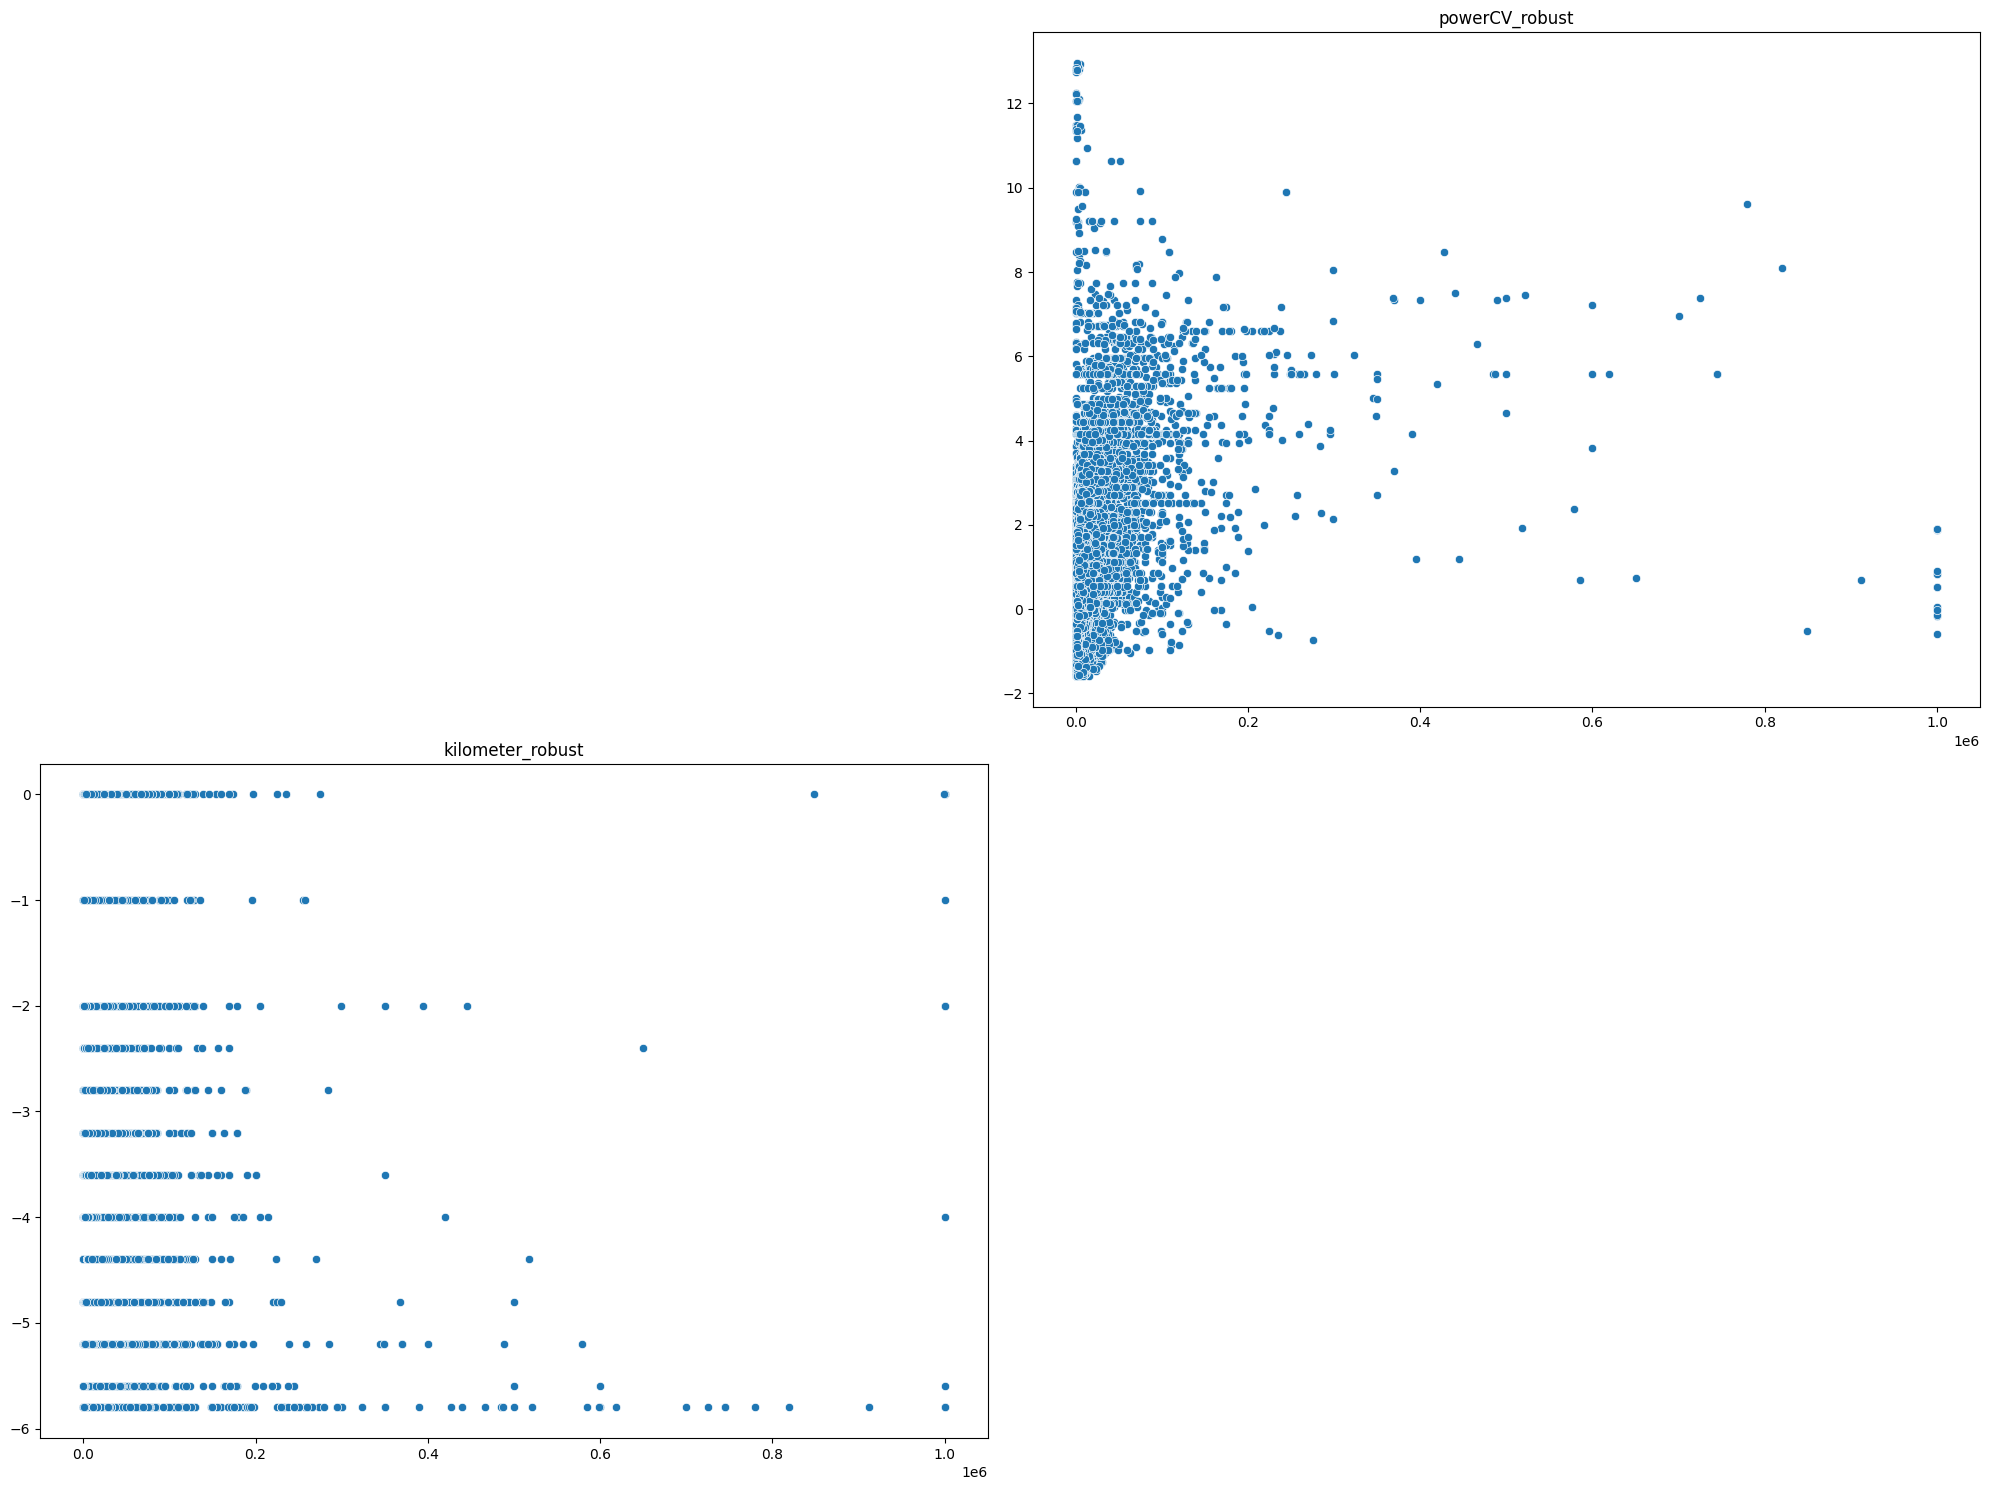

In [8]:
# instanciamos la clase de indentificación de Outliers Multivariados. En este caso usamos las funciones definidas en los apuntes
gestion_multi= so.GestionOutliersMultivariados(df)

# llamamos al método que nos permite identificar los outliers
gestion_multi.visualizar_outliers_bivariados("price")

Los diagramas de dispersión visualizan muy bien los *outliers* pero no los identifican en el conjunto de datos

Vamos a usar el metodo LOF para detectar los outliers multivariados, parece el más adecuado dado que tenemos datos muy similares y muy variados

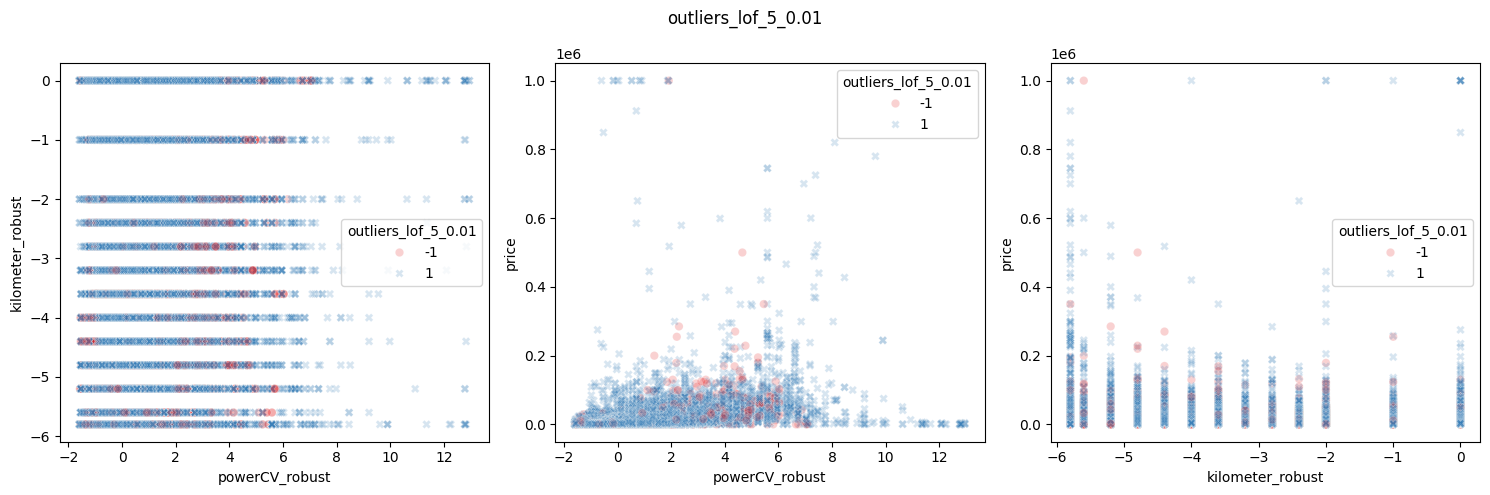

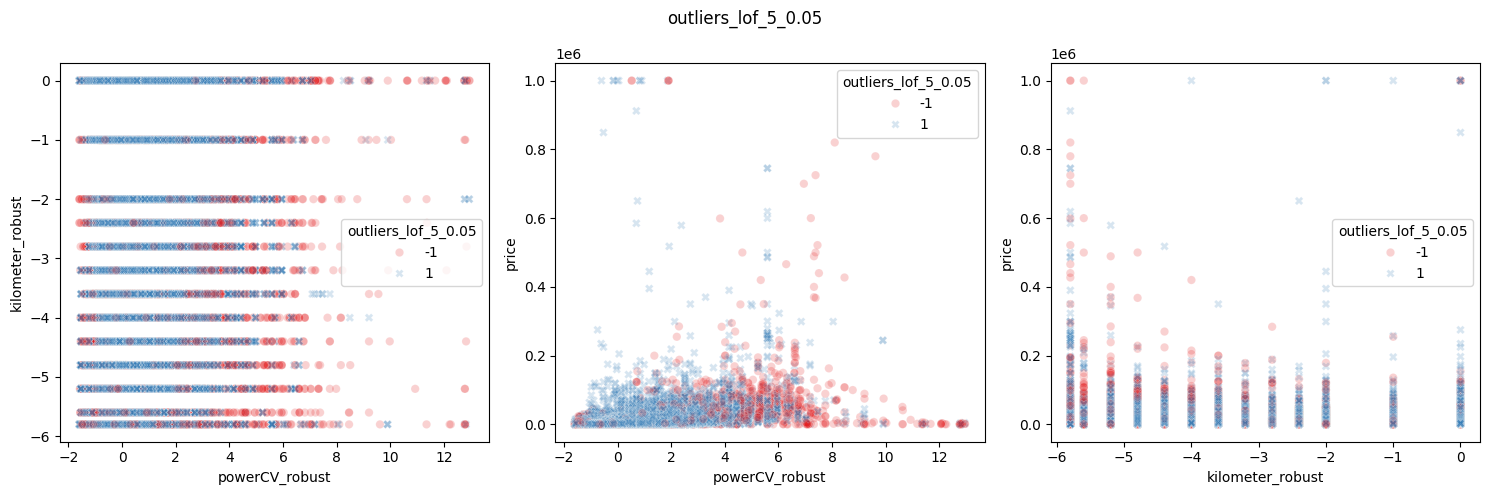

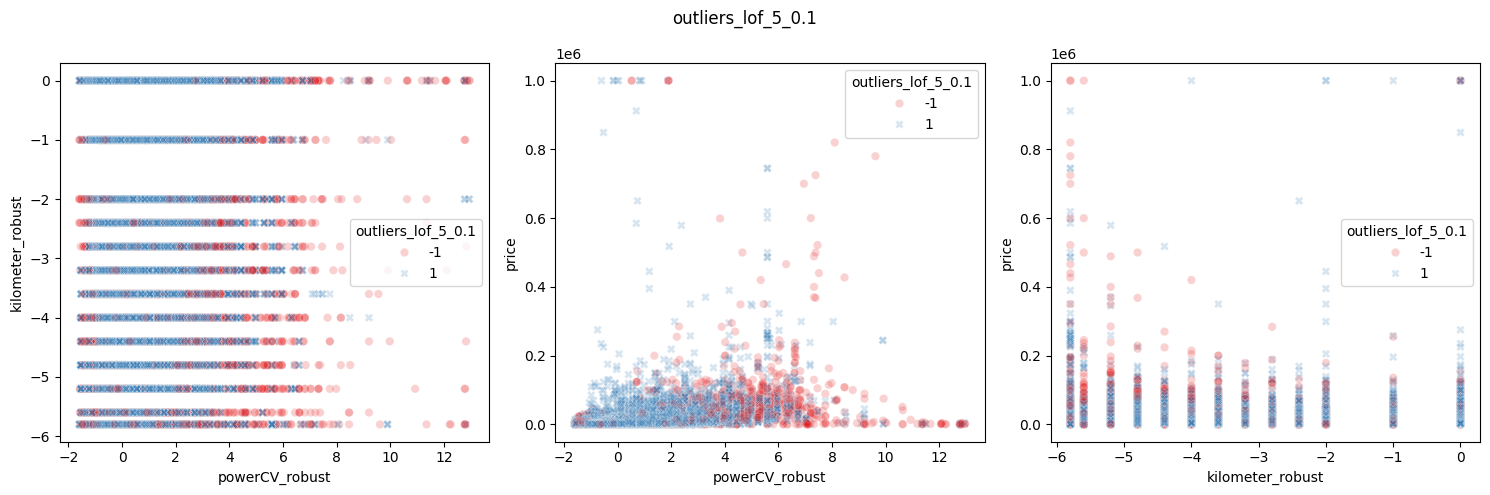

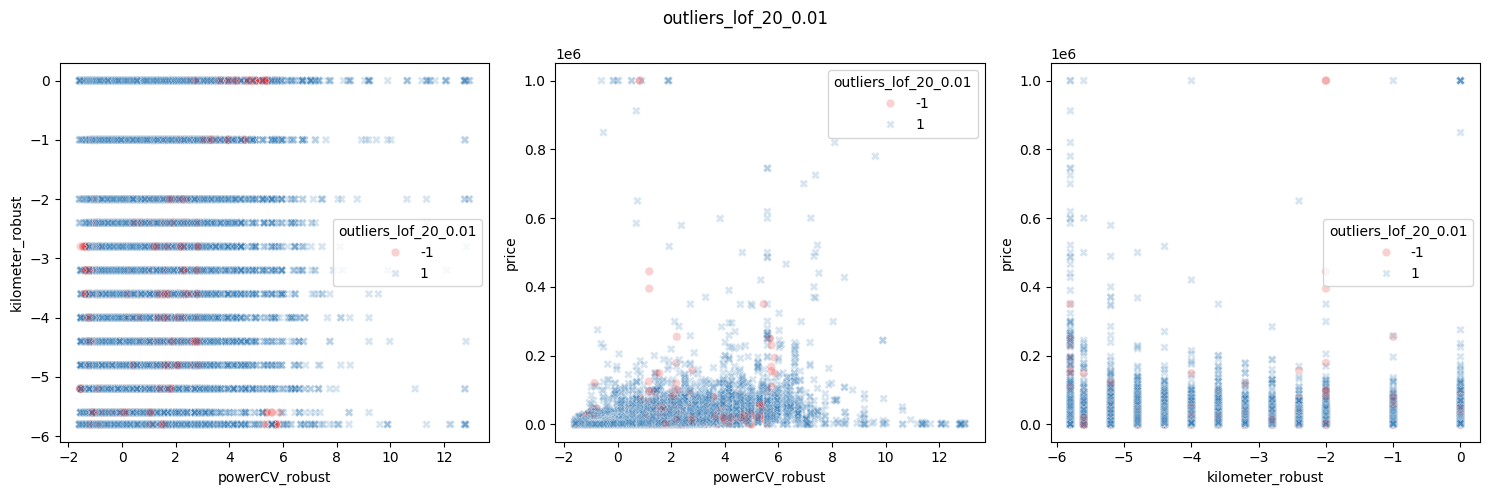

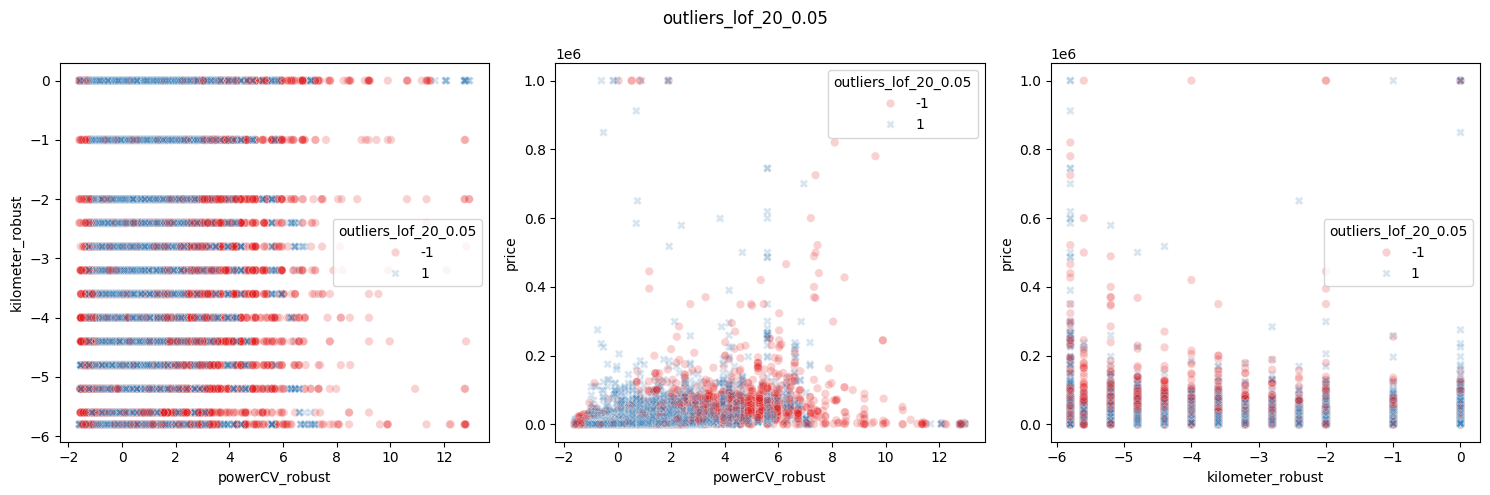

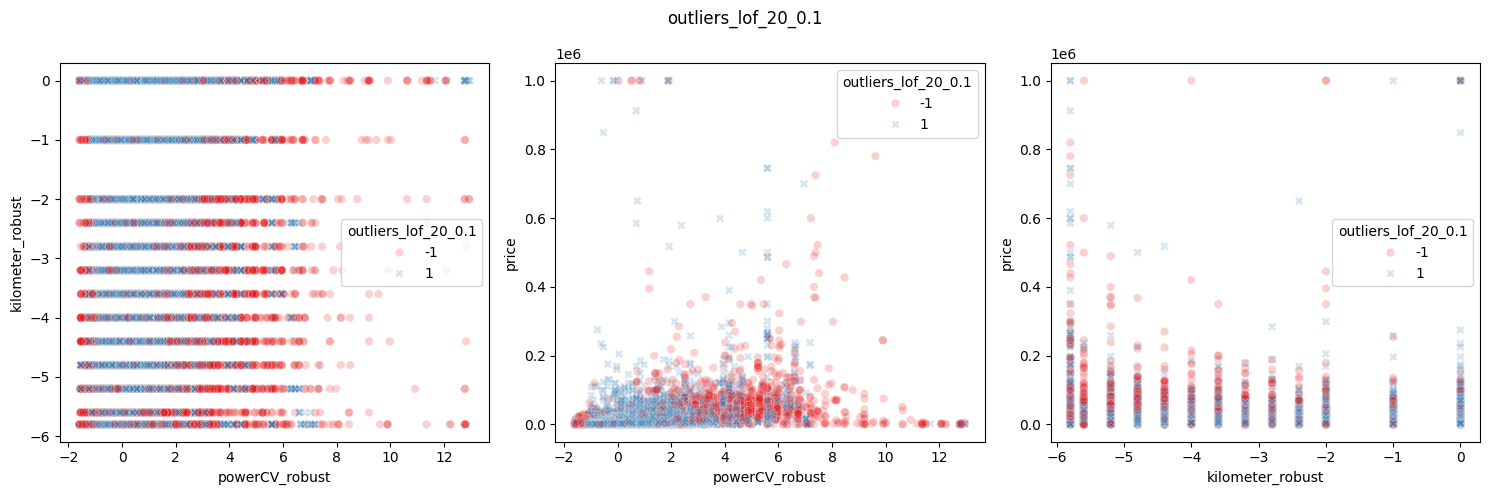

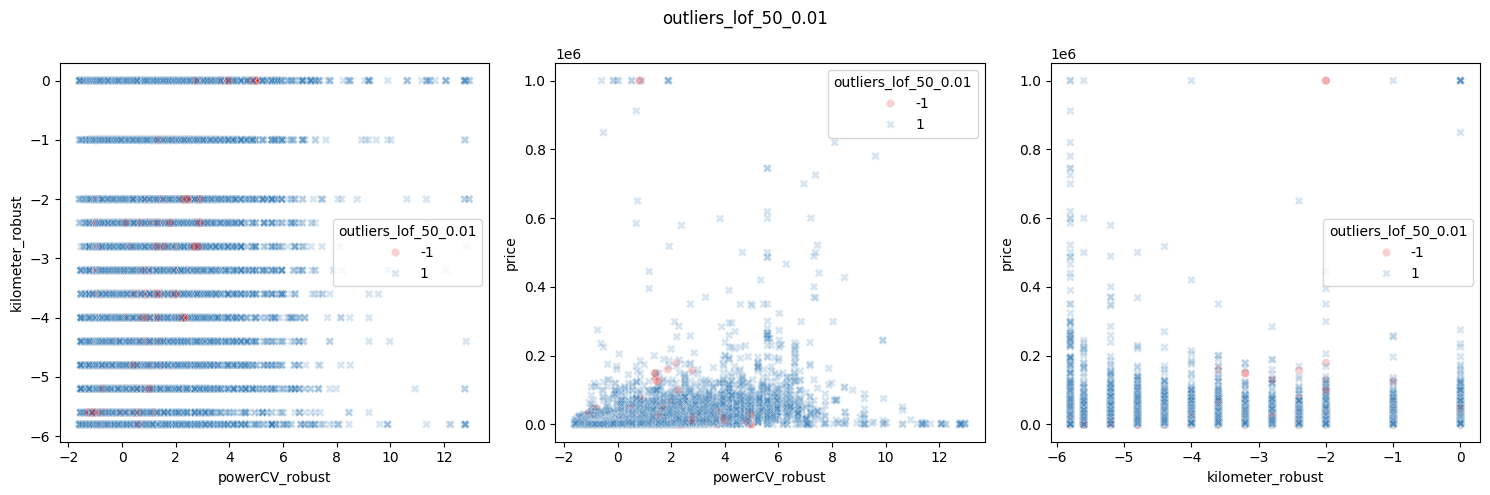

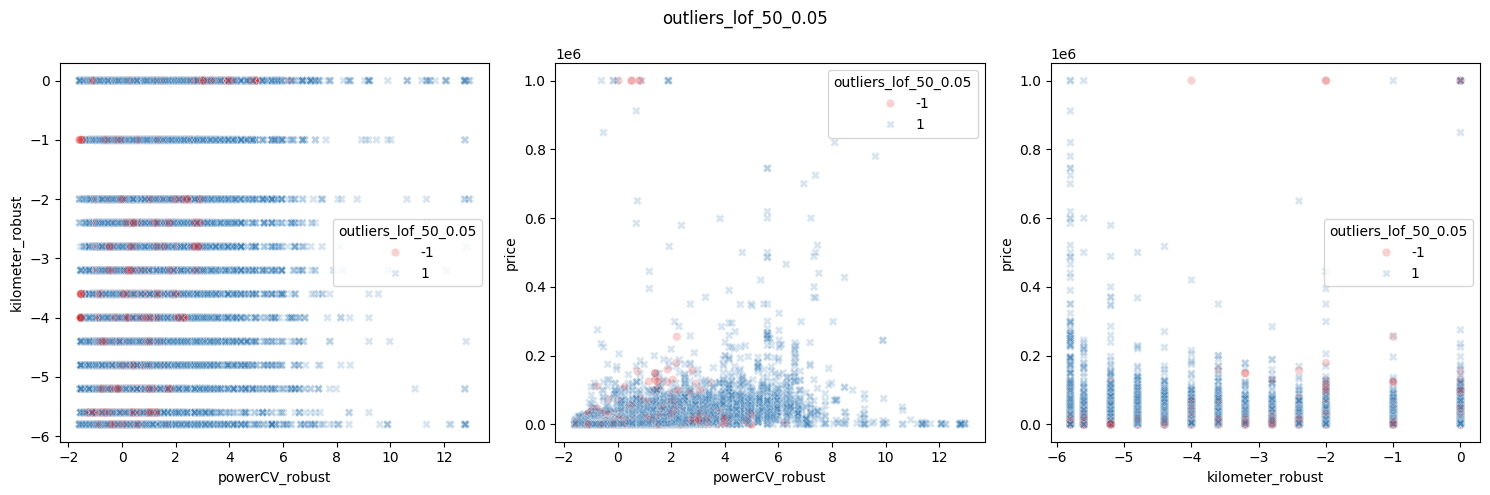

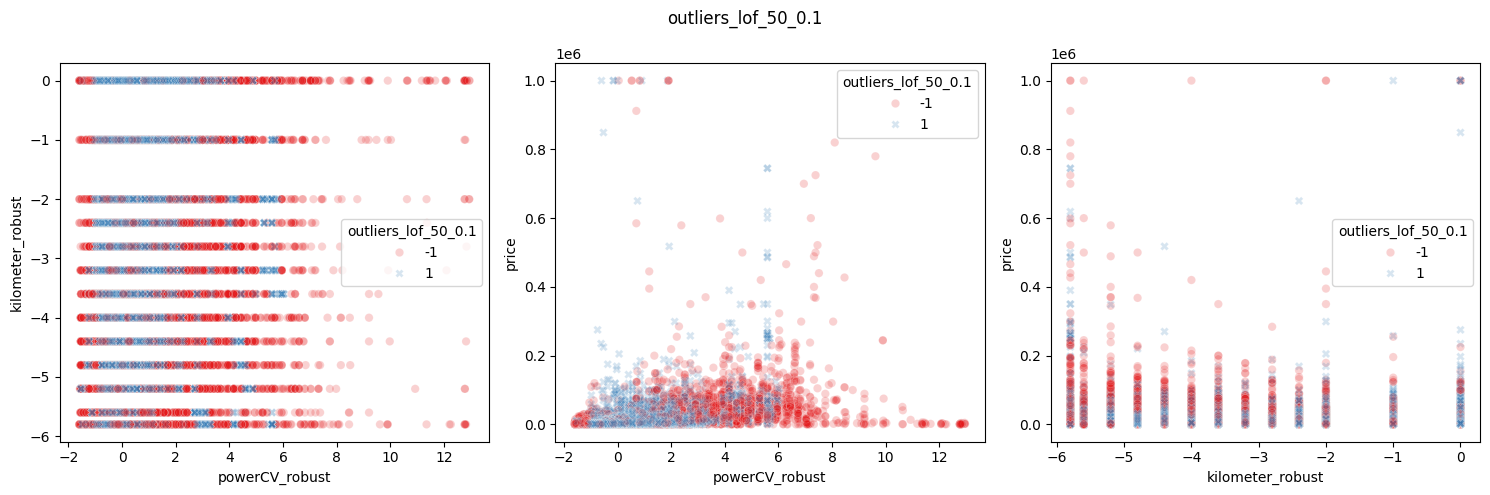

In [9]:
def gestion_nulos_lof(df, col_numericas, list_neighbors, lista_contaminacion):
    
    combinaciones = list(product(list_neighbors, lista_contaminacion))
    
    for neighbors, contaminacion in combinaciones:
        lof = LocalOutlierFactor(n_neighbors=neighbors, 
                                 contamination=contaminacion,
                                 n_jobs=-1)
        df[f"outliers_lof_{neighbors}_{contaminacion}"] = lof.fit_predict(df[col_numericas])

    return df

col_numericas=['powerCV_robust', 'kilometer_robust']
lista_vecinos=[5, 20, 50]
list_contaminacion = [0.01, 0.05, 0.1]

df_lof = df.copy()
df_lof = gestion_nulos_lof(df_lof, col_numericas, lista_vecinos, list_contaminacion)

combinaciones_variables = list(combinations(['powerCV_robust', 'kilometer_robust', 'price'], 2))
columnas_hue = df_lof.filter(like="outlier").columns

for col_hue in columnas_hue:
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
    axes = axes.flat

    for indice, tupla in enumerate(combinaciones_variables):
        sns.scatterplot(df_lof, x=tupla[0], y=tupla[1], ax=axes[indice], hue = col_hue, palette="Set1", style=col_hue, alpha=0.2)
        plt.suptitle(f"{col_hue}")
        plt.tight_layout()

In [10]:
df_lof.head()

,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
0,480.0,-0.369107,0.0,1,1,1,1,1,1,1,1,-1
1,18300.0,1.123815,-1.0,1,1,1,1,1,1,1,1,1
2,9800.0,0.744345,-1.0,1,1,1,1,1,1,1,1,1
3,1500.0,-0.525420,0.0,1,1,1,1,1,1,1,1,1
4,3600.0,-0.612990,-2.4,1,1,1,1,1,1,1,1,1


In [11]:
df_iterative = pd.read_csv("datos/iterative.csv", index_col=0)

In [12]:
df_iterative= df_iterative.drop(columns=['price', 'powerCV', 'kilometer'])


In [13]:
df_outliers =  pd.concat([df_iterative, df_lof], axis=1)

In [14]:
df_outliers.shape

(371528, 28)

Consideraremos outliers aquellas filas que contengan más de 60% de outliers, en este caso, tenemos 9 columnas de outliers, que serían 5/9.

In [15]:
cantidad = 5
df_filtrado = df_outliers[(df_outliers == -1).sum(axis=1) > cantidad]


In [16]:
df_filtrado.head()

,dateCrawled,name,seller,offerType,abtest,vehicleType,yearOfRegistration,gearbox,model,monthOfRegistration,...,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
32,2016-03-15 20:59:01,Golf_3_....._1.4,private,offer,test,NaN,1994.0,NaN,golf,2,...,0.0,1,-1,-1,1,-1,-1,1,-1,-1
104,2016-03-16 16:44:10,Hyundai_Genesis_Coupe_GT_3.8_V6_Automatik,private,offer,control,coupe,2012.0,automatic,andere,4,...,-4.0,-1,-1,-1,-1,-1,-1,1,1,-1
134,2016-03-20 18:47:31,BMW_E36_328i_Coupe_Schalter,private,offer,test,NaN,2000.0,NaN,3er,2,...,0.0,1,-1,-1,1,-1,-1,1,-1,-1
152,2016-03-15 12:50:00,Krankenfahrstuhl_25_kmh__zu_verkaufen.,private,offer,control,NaN,2005.0,manually,punto,9,...,-4.4,-1,-1,-1,-1,-1,-1,-1,-1,-1
162,2016-03-23 14:45:57,Kia_Sorento__coole_Farbe_schaut......,private,offer,test,suv,2007.0,automatic,sorento,11,...,-5.8,-1,-1,-1,-1,-1,-1,1,1,-1


In [17]:
df_outliers.describe()


,yearOfRegistration,monthOfRegistration,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
count,371346.000000,371528.000000,371528.00000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000,371528.000000
mean,2003.348489,5.734445,50820.66764,5933.228729,0.178809,-0.975252,0.979996,0.957252,0.957252,0.979996,0.899997,0.896185,0.979996,0.900029,0.824901
std,7.776980,3.712412,25799.08247,12045.108606,0.879299,1.604493,0.199017,0.289255,0.289255,0.199017,0.435897,0.443680,0.199017,0.435830,0.565277
min,1910.000000,0.000000,1067.00000,1.000000,-1.590856,-5.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1999.000000,3.000000,30459.00000,1290.000000,-0.445390,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2003.000000,6.000000,49610.00000,3000.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,2008.000000,9.000000,71546.00000,7300.000000,0.554610,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,2019.000000,12.000000,99998.00000,999999.000000,12.960364,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
visualizador = sp.Visualizador(df_filtrado)

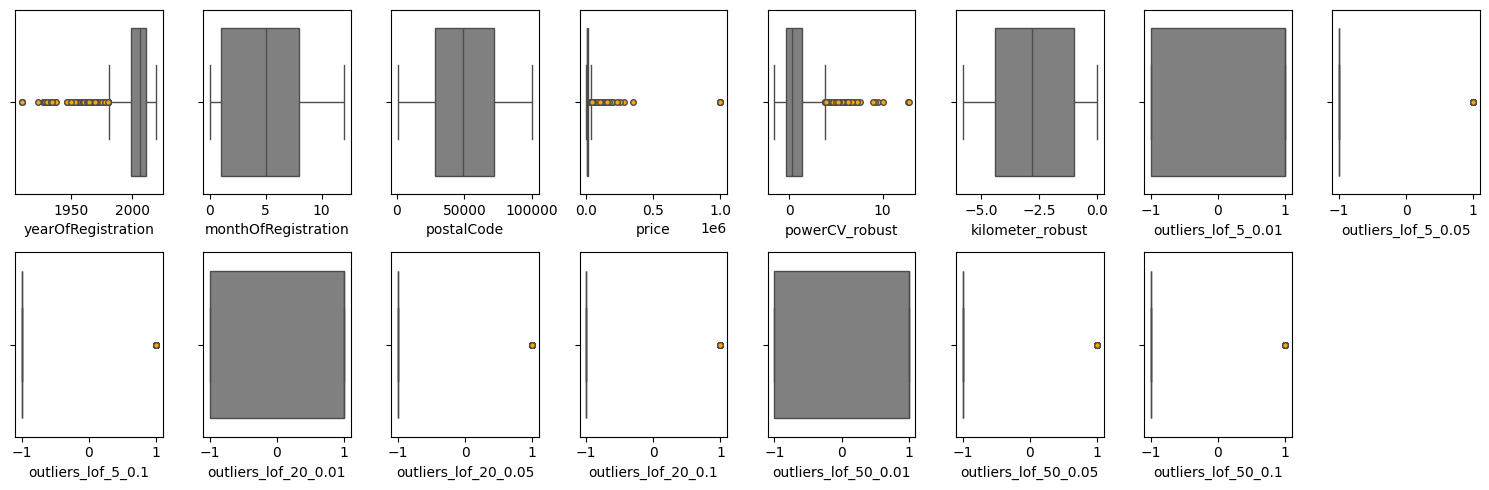

In [19]:
visualizador.deteccion_outliers()

In [20]:
df_filtrado.describe()

,yearOfRegistration,monthOfRegistration,postalCode,price,powerCV_robust,kilometer_robust,outliers_lof_5_0.01,outliers_lof_5_0.05,outliers_lof_5_0.1,outliers_lof_20_0.01,outliers_lof_20_0.05,outliers_lof_20_0.1,outliers_lof_50_0.01,outliers_lof_50_0.05,outliers_lof_50_0.1
count,7069.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.000000,7105.00000,7105.000000
mean,2002.147546,5.075158,50293.898241,11887.072353,0.634928,-2.714539,0.044053,-0.697115,-0.697115,0.230401,-0.987896,-0.993244,0.348628,-0.55102,-0.972977
std,13.708250,3.809436,26198.371909,30410.906699,1.390244,1.845543,0.999099,0.717010,0.717010,0.973164,0.155130,0.116051,0.937327,0.83455,0.230919
min,1910.000000,0.000000,1099.000000,1.000000,-1.590856,-5.800000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
25%,1999.000000,1.000000,28207.000000,2300.000000,-0.398042,-4.400000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,-1.000000
50%,2006.000000,5.000000,48712.000000,7480.000000,0.300604,-2.800000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.00000,-1.000000
75%,2011.000000,8.000000,71665.000000,15500.000000,1.313550,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,1.000000,-1.00000,-1.000000
max,2019.000000,12.000000,99986.000000,999999.000000,12.799819,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


<Axes: xlabel='kilometer_robust', ylabel='price'>

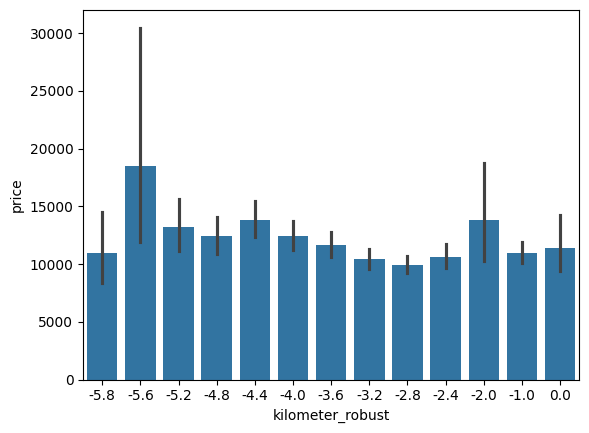

In [21]:
sns.barplot(df_filtrado, x="kilometer_robust", y="price")


Tenemos aproximadamente 7105 outliers, dado que no tenemos información sobre si se encuentran en la columna de kilometer o powerCV, reemplazaremos por la mediana en cada uno de los casos, dado que reducimos el impacto de eliminar datos, y evitamos la sensibilidad de la media a los valores extremos. No tenemos evidencias para eliminar los datos, recordemos, que aquellos datos que consideramos que podrian ser erroneos los eliminamos en el notebook de eda-nulos,  y siendo la distribución no normal, sustituiremos con este método.

In [22]:
df_filtrado["powerCV_robust"].mean()

np.float64(0.6349281820354248)

In [23]:
df_outliers.loc[df_filtrado.index, "kilometer_robust"] = df_filtrado["kilometer_robust"].mean()
df_outliers.loc[df_filtrado.index, "powerCV_robust"] = df_filtrado["powerCV_robust"].mean()
df_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
yearOfRegistration,371346.0,2003.348489,7.776980,1910.000000,1999.000000,2003.000000,2008.00000,2019.000000
monthOfRegistration,371528.0,5.734445,3.712412,0.000000,3.000000,6.000000,9.00000,12.000000
postalCode,371528.0,50820.667640,25799.082470,1067.000000,30459.000000,49610.000000,71546.00000,99998.000000
price,371528.0,5933.228729,12045.108606,1.000000,1290.000000,3000.000000,7300.00000,999999.000000
powerCV_robust,371528.0,0.178809,0.858027,-1.590856,-0.423255,0.037473,0.55461,12.960364
kilometer_robust,371528.0,-0.975252,1.584068,-5.800000,-2.000000,0.000000,0.00000,0.000000
outliers_lof_5_0.01,371528.0,0.979996,0.199017,-1.000000,1.000000,1.000000,1.00000,1.000000
outliers_lof_5_0.05,371528.0,0.957252,0.289255,-1.000000,1.000000,1.000000,1.00000,1.000000
outliers_lof_5_0.1,371528.0,0.957252,0.289255,-1.000000,1.000000,1.000000,1.00000,1.000000
outliers_lof_20_0.01,371528.0,0.979996,0.199017,-1.000000,1.000000,1.000000,1.00000,1.000000


In [24]:
df_outliers = df_outliers[['dateCrawled', 'name', 'seller', 'offerType', 'price', 'abtest',
       'vehicleType', 'yearOfRegistration', 'gearbox', 'model',
       'monthOfRegistration', 'fuelType', 'brand', 'notRepairedDamage',
       'dateCreated', 'lastSeen', 'kilometer_robust', 'powerCV_robust']]

In [25]:
df_outliers.to_csv("datos/outliers_num.csv")